In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')
sns.set(font_scale=2.5)

In [3]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [4]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline

In [6]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [7]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

In [8]:
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## Feature Engineering
 - dataset에 존재하는 null data를 채워야 함
 - 아무 값으로 채우는 것이 아니고, null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어로 채울 수 있음
 - null data를 어떤 값으로 채우냐에 따라 성능이 좌지우지 될 수 있음
 - feature engineering은 실제 모델 학습에 쓰이므로, train 뿐만 아니라 test에도 똑같이 적용해줘야 함

## Fill Null in Age using title
 - Age에 177개의 null 데이터가 있는데, 이를 채우기 위해 title + statistics를 사용
 - 영어엔 Miss, Mr, Mrs와 같은 title이 존재하고, 각 탑승객의 이름에는 이러한 title이 들어가므로 이를 활용
 - pandas series에 data를 string으로 바꿔주는 str method, 정규표현식을 적용하게 해주는 extract method가 있으므로 이를 사용해서 title을 추출

In [9]:
# 추출한 title을 initial 컬럼에 저장
df_train['initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [10]:
# pandas의 crosstab을 이용하여 추출한 initial과 Sex 간의 count를 비교
pd.crosstab(df_train['initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [11]:
# replace 메소드를 사용하여 남녀가 쓰는 initial을 구분 (기존 값을 Master, Miss, Mr, Mrs, Other로 통합)
df_train['initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'],inplace=True)
df_test['initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'],inplace=True)

In [12]:
# 여성과 관계된 initial인 Miss, Mrs의 생존률이 높음
df_train.groupby('initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


<AxesSubplot:xlabel='initial'>

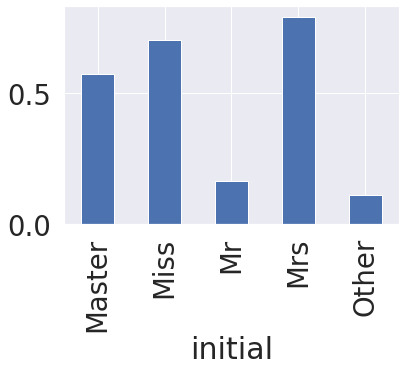

In [13]:
df_train.groupby('initial')['Survived'].mean().plot.bar()

 - null data를 채우는 방법에는 statistics를 활용하는 방법과 not null data를 기반으로 머신러닝 등의 알고리즘을 통해 예측해서 채워넣는 방법이 있음
 - 이 커널에선 statistics를 활용하는 방법을 사용
 - statistics는 train data 를 활용함. test는 unseen 상태로 항상 놔둬야 하고, train에서 얻은 statistics를 기반으로 train의 null data를 채울 것

In [14]:
df_train.groupby('initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


 - Age의 평균 값을 이용하여 null 값을 채움
 - pandas의 데이터프레임을 다룰 때에는 boolean array를 이용해서 indexing 하면 편함
 - 아래는 isnull() 이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age'의 값을 33으로 치환함을 의미
 - *** loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰임 ***

In [15]:
df_train.loc[(df_train.Age.isnull())&(df_train.initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.initial=='Other'), 'Age'] = 46

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  initial      891 non-null    object 
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


In [17]:
df_test.loc[(df_test.Age.isnull())&(df_test.initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.initial=='Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.initial=='Other'), 'Age'] = 46

## Fill Null in Embarked
 - Embarked의 null 값은 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 S로 null 값을 채움
 - dataframe의 fillna method를 이용하여 채우면 됨. inplace=True는 df_train에 fillna를 실제로 적용함을 의미

In [18]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


In [19]:
df_train['Embarked'].fillna('S', inplace=True)
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  0  Null values


## Change Age (continuous variable to categorial variable)
 - continuous feature의 Age를 몇 개의 그룹으로 나눠 categoray화를 진행
 - continuous를 categorical하게 바꾸면 information loss가 발생할 수도 있음을 주의할 것
 - dataframe의 indexing 방법인 loc를 사용하여 직접 할 수도 있고, apply를 사용하여 함수를 넣어줄 수 있음

### 1. loc 를 사용한 방법

In [20]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

### 2. 함수를 만들어 apply method에 넣어주는 방법

In [21]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [22]:
# 위의 두 방법은 같은 결과를 내야 함
# 이를 확인하기 위해 Series 간 boolean 비교 후 all() method를 사용. all()은 모든 값이 True면 True, 아니면 False를 반환
print('1번 방법, 2번 방법 둘 다 같은 결과를 내면 True -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘 다 같은 결과를 내면 True ->  True


In [23]:
# 중복되는 Age_cat_2과 원래 컬럼인 Age를 제거
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## Change initial, Embarked and Sex (string to numerical)
 - Initial은 Mr, Mrs, Miss, Master, Other 총 5개의 카테고리로 표현되어 있음. 이를 모델에 input으로 넣을 때 컴퓨터가 인식할 수 있도록 수치화시켜야 함

In [24]:
df_train['initial'] = df_train['initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['initial'] = df_test['initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

In [25]:
# 특정 column에 어떤 값들이 있는 지 확인해보는 방법으로 unique() method가 있고, value_counts()로 count까지 살펴볼 수 있음
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [26]:
# Embarked는 C, Q, S로 이루어져 있음
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [27]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

 - null 값 있는지 확인
 - Embarked 컬럼만 가져온 것은 하나의 pandas의 Series 객체이므로, isnull()을 사용해 null 인지 아닌지에 대한 boolean 값 반환 가능
 - any()를 사용하면, True가 하나라도 있을 시에 True를 반환함
 - null 값을 모두 'S'로 바꿨으므로 False가 반환되어야 함

In [28]:
df_train['Embarked'].isnull().any()

False

In [29]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

## feature 간의 상관관계 파악
 - 두 변수 간의 Pearson correlation을 구하면 (-1, 1) 범위 내의 값을 얻을 수 있음
 - -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며 0은 상관관계가 없음을 의미
 - 현재 데이터에는 여러 feature가 포함되어 있어서 이를 하나의 matrix 형태로 보면 편한데, 이를 heatmap plot이라고 함

In [30]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'initial', 'Age_cat']]

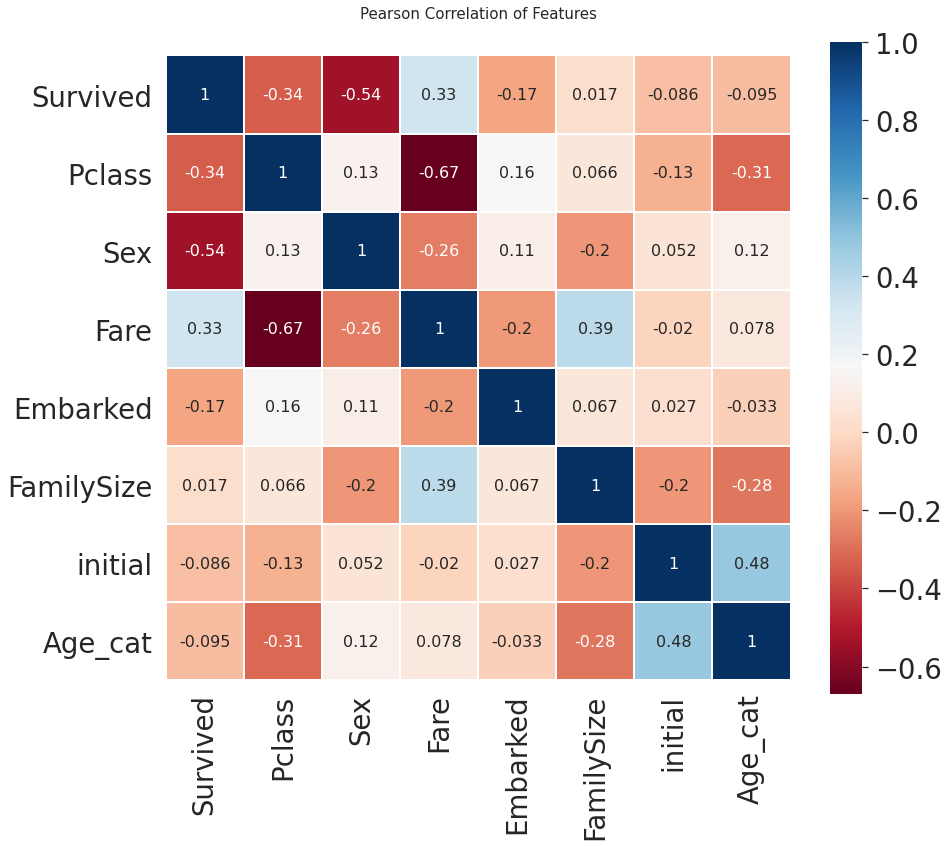

In [31]:
# dataframe의 corr() 메소드와 seaborn을 통해 heatmap plot을 쉽게 그릴 수 있음
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size":16})
del heatmap_data

 - Sex와 Pclass가 Survived에 상관관계가 어느 정도 있음을 볼 수 있음
 - fare와 Embarked도 생각보다 상관관계가 있음
 - 서로 강한 상관관계를 가지는 feature들은 없음
 - 이는 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature가 없음을 의미함. 1 or -1의 상관관계를 가진 feature A,B가 있다면 얻을 수 있는 정보는 하나뿐이기 때문

## One-hot encoding on initial and Embarked
 - 수치화시킨 카테고리 데이터를 그대로 input으로 사용해도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 진행
 - 수치화란 Master:0, Miss:1, Mr:2, Mrs:3, Other:4 처럼 매핑해주는 것을 의미
 - one-hot encoding은 위 카테고리를 (0,1)로 이루어진 5차원의 벡터로 나타내는 것
 - pandas의 get_dummies를 사용하여 one-hot encoding이 가능함

In [32]:
df_train = pd.get_dummies(df_train, columns=['initial'], prefix='initial')
df_test = pd.get_dummies(df_test, columns=['initial'], prefix='initial')

In [33]:
# initial은 5개의 카테고리를 가지고 있으므로 5개의 columns이 새로 생성됨
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,initial_0,initial_1,initial_2,initial_3,initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [34]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         418 non-null    float64
 8   Cabin        91 non-null     object 
 9   FamilySize   418 non-null    int64  
 10  Age_cat      418 non-null    int64  
 11  initial_0    418 non-null    uint8  
 12  initial_1    418 non-null    uint8  
 13  initial_2    418 non-null    uint8  
 14  initial_3    418 non-null    uint8  
 15  initial_4    418 non-null    uint8  
 16  Embarked_0   418 non-null    uint8  
 17  Embarked_1   418 non-null    uint8  
 18  Embarked_2   418 non-null    uint8  
dtypes: float

 - sklearn으로 Labelencoder + OneHotencoder를 이용해도 one-hot encoding 가능
 - category 값이 100개가 넘어가면 one-hot encoding 시 column이 100개가 생겨 학습 성능에 지장을 줄 수 있음

## Drop columns
 - 필요한 컬럼만 남기고 다 지우기

df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [37]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,initial_0,initial_1,initial_2,initial_3,initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [38]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,initial_0,initial_1,initial_2,initial_3,initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


 - train의 Survived feature(target class)를 제외하면 train, test 둘 다 같은 columns를 가짐

## Building machine learning model and prediction using the trained model

In [39]:
# importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics # 모델 평가를 위해 사용
from sklearn.model_selection import train_test_split

- 타이타닉 문제는 target class(survived)가 있으며, 값은 0과 1로 이루어진 binary classification 문제
- 가지고 있는 train set의 survived를 제외한 input으로 모델을 최적화시켜서 각 샘플(탑승객)의 생존 유무를 판단하는 모델을 생성
- 이후 모델이 학습하지 않았던 test set을 input으로 줘서 test set의 각 샘플(탑승객)의 생존 유무를 예측

## Preparation - Split dataset into train, valid, test set
- drop을 사용해 학습 데이터와 target label(survived)을 분리

In [40]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [41]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- random-forest는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델
- 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요하므로 현재 튜토리얼에선 안 하고, default 세팅으로 진행
- 모델 객체를 만들고, fit 메소드로 학습시킨 후, valid set input을 넣어서 예측값(X_vld sample(탑승객)의 생존 여부)를 얻게 됨

### Model generation and prediction

In [43]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [44]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 80.97% 정확도로 생존을 맞춤


## Feature importance
- 학습된 모델은 feature importance를 가지게 되는데, 이를 통해 지금 만든 모델이 어떤 feature에 영향을 많이 받는지 확인할 수 있음
- pandas의 Series를 이용하면 쉽게 sorting하여 그래프 그릴 수 있음

In [45]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

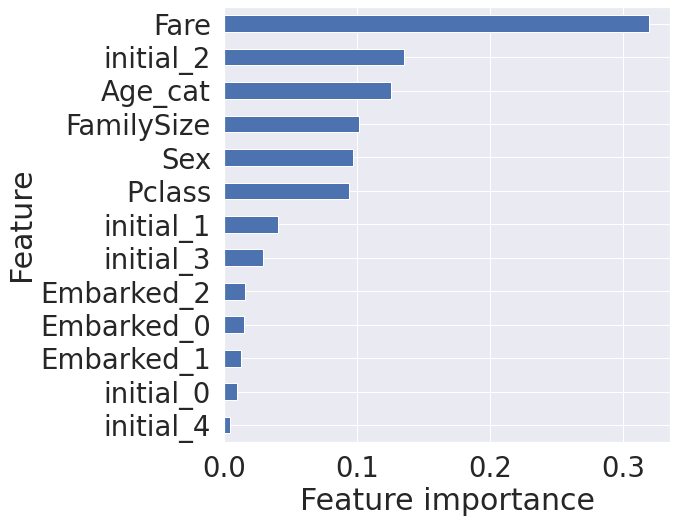

In [46]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- Fare가 가장 큰 영향력을 가지며, 이후 initial_2와 Age_cat, Pclass가 차례로 중요도를 가짐
- feature importance는 현재 모델에 대한 feature importance이므로 다른 모델을 사용하면 결과가 다르게 나올 수 있음
- 아래 결과를 보고 실제로 Fare가 중요한 feature일 수 있다고 판단할 수 있지만, 이는 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴봐야 함
- feature importance를 통해 모델의 정확도를 높이기 위해 feature selection을 할 수도 있고, 모델의 속도 향상을 위해 feature를 제거할 수도 있음

## Prediction on Test set

In [47]:
submission = pd.read_csv('./input/gender_submission.csv')

In [48]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [49]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [50]:
submission.to_csv('./my_first_submission.csv', index=False)